In [1]:
import pandas as pd
import numpy as np
import random
import gzip

# MNIST preprocessing to tabular data
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    X_data = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
    digit_label = np.frombuffer(f.read(), np.uint8, offset=8)

X_data = pd.DataFrame(X_data)
X_data['digit_label'] = digit_label

In [39]:
normal_data = X_data.loc[X_data.digit_label == 1].reset_index(drop=True)
abnormal_data = X_data.loc[X_data.digit_label != 1].reset_index(drop=True)
random.seed(221117)
abnormal_data = abnormal_data.loc[random.sample(range(abnormal_data.shape[0]), 20), :]
abnormal_data.digit_label.value_counts()

5    4
6    4
7    2
9    2
0    2
2    2
3    2
4    1
8    1
Name: digit_label, dtype: int64

## 1. SVM 적용

In [40]:
total_data = pd.concat([normal_data.iloc[:,:784], abnormal_data.iloc[:,:784]])
total_data['abnormal'] = np.repeat(0,normal_data.shape[0]).tolist()+np.repeat(1,abnormal_data.shape[0]).tolist()
total_data = total_data.reset_index(drop=True)
total_data

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,abnormal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
from sklearn.metrics import confusion_matrix
def evaluation(fold_num, model, trn_X, trn_y, tst_X, tst_y, data):
    y_pred = model.predict(trn_X)
    tn, fp, fn, tp = confusion_matrix(trn_y, y_pred).ravel()
    data.loc[fold_num, 'trn_accuracy'] = (tp+tn)/(tn+fp+fn+tp)
    data.loc[fold_num, 'trn_f1'] = 2*tp/(fp+2*tp+fn)
    

    y_pred = model.predict(tst_X)
    tn, fp, fn, tp = confusion_matrix(tst_y, y_pred).ravel()
    data.loc[fold_num, 'tst_accuracy'] = (tp+tn)/(tn+fp+fn+tp)
    data.loc[fold_num, 'tst_f1'] = 2*tp/(fp+2*tp+fn)

    return data

eval_data = pd.DataFrame([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]], columns=['trn_accuracy', 'trn_f1', 'tst_accuracy', 'tst_f1'])

In [42]:
def kfold(data, fold, seed):
    import random
    idx_set_1 = data.loc[data.abnormal== 1].index.tolist()
    idx_set_0 = data.loc[data.abnormal == 0].index.tolist()
    size_1 = round(len(idx_set_1)/fold)
    size_0 = round(len(idx_set_0)/fold)
    folded_idx_set = []
    for i in range(fold):
        if (i == fold-1):
            folded_idx_set.append(idx_set_1+idx_set_0)
        else:
            random.seed(seed)   
            folded_idx_set.append(list(random.sample(idx_set_1, size_1))+list(random.sample(idx_set_0, size_0)))
            idx_set_1 = list(set(idx_set_1)-set(folded_idx_set[len(folded_idx_set)-1]))
            idx_set_0 = list(set(idx_set_0)-set(folded_idx_set[len(folded_idx_set)-1]))
    
    return folded_idx_set

In [43]:
kfold_idx_set = kfold(data=total_data, fold=5, seed=1117)

trn_X = []
trn_y = []
tst_X = []
tst_y = []
index_set = total_data.index.tolist()

for i in range(5):
    total_idx = set(index_set)
    trn_X.append(total_data.loc[list(total_idx-set(kfold_idx_set[i])), list(range(0,784))])
    trn_y.append(total_data.loc[list(total_idx-set(kfold_idx_set[i])), 'abnormal'])
    tst_X.append(total_data.loc[kfold_idx_set[i], list(range(0,784))])
    tst_y.append(total_data.loc[kfold_idx_set[i]]['abnormal'])

In [44]:
from sklearn.svm import SVC
for i in range(5):
    fold_num = i
    model = SVC(kernel='rbf', C=1)
    model.fit(trn_X[fold_num], trn_y[fold_num])
    eval_data = evaluation(fold_num, model, trn_X[fold_num], trn_y[fold_num], tst_X[fold_num], tst_y[fold_num], eval_data)

eval_data

   trn_accuracy    trn_f1  tst_accuracy  tst_f1
0      0.999630  0.933333      0.997041       0
1      0.999445  0.896552      0.997041       0
2      0.999445  0.896552      0.997041       0
3      0.999815  0.967742      0.997041       0
4      0.999445  0.896552      0.997046       0
trn_accuracy    0.999556
trn_f1          0.918146
tst_accuracy    0.997042
tst_f1          0.000000
dtype: float64


In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore") # warning 무시

In [46]:
tsne = TSNE(n_components=2, random_state = 1117)
tsne_data = tsne.fit_transform(total_data[list(range(0,784))])
tsne_data = pd.DataFrame(tsne_data, columns=['z1', 'z2'])

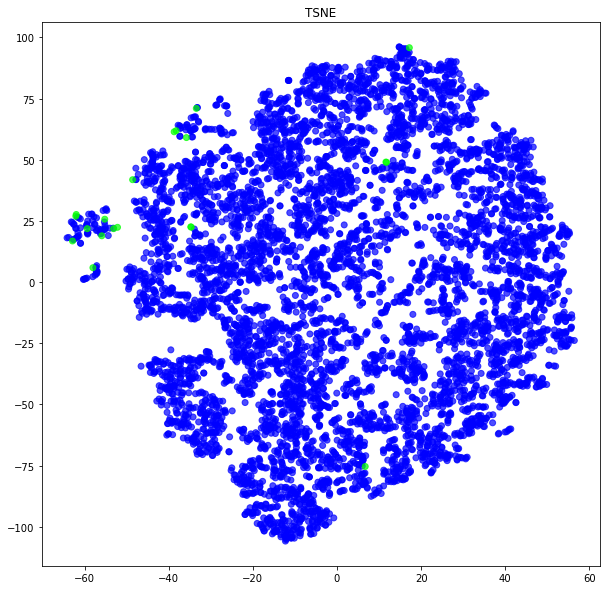

In [47]:
plt.figure(figsize=(10,10))
plt.title('TSNE')
plt.scatter(tsne_data.z1, tsne_data.z2, c=total_data.abnormal, cmap=plt.cm.brg, alpha=0.7)

# Gaussian Density Estimation VS MoG

In [107]:
from sklearn.mixture import GaussianMixture
import time

In [108]:
random.seed(221117)
trn_idx_set = list(random.sample(range(normal_data.shape[0]), round(normal_data.shape[0]*0.8)))
tst_idx_set = list(set(normal_data.index)-set(trn_idx_set))
trn_data = normal_data.iloc[trn_idx_set,:784].reset_index(drop=True)
tst_data = normal_data.iloc[tst_idx_set,:784]
tst_data = pd.concat([abnormal_data.iloc[:,:784], tst_data]).reset_index(drop=True)
tst_y = list(np.repeat(1,20))+list(np.repeat(0,len(tst_idx_set)))

In [111]:
eval_data = pd.DataFrame([[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]], 
columns=['n_gaussian', 'cov_type', 'time', 'tst_accuracy', 'tst_f1', 'tp', 'fn', 'tn', 'fp'])

In [112]:
iter = 1
for n_gaussian in [1,2,3,4,5]:
    for cov_type in ['spherical', 'diag', 'full']:
        print('n_gaussian:{}, cov_type: {}'.format(n_gaussian, cov_type))
        st = time.time()
        model = GaussianMixture(n_components=n_gaussian, random_state=1117, covariance_type=cov_type).fit(trn_data)
        et = time.time()
        print('time:', et-st)
        y_pred = model.predict(tst_data)
        cm = confusion_matrix(tst_y, y_pred)
        tn = cm[0,0]
        fp = np.sum(cm[0,1:])
        fn = np.sum(cm[1:,0])
        tp = np.sum(cm[1:,1:])
        
        
        eval_data.iloc[iter-1, :] = [n_gaussian, cov_type, et-st, (tp+tn)/(tn+fp+fn+tp), 2*tp/(fp+2*tp+fn), tp, fn, tn, fp]

        iter = iter+1

n_gaussian:1, cov_type: spherical
time: 0.14583420753479004
n_gaussian:1, cov_type: diag
time: 0.15365147590637207
n_gaussian:1, cov_type: full
time: 0.41888928413391113
n_gaussian:2, cov_type: spherical
time: 0.31734132766723633
n_gaussian:2, cov_type: diag
time: 0.37874293327331543
n_gaussian:2, cov_type: full
time: 5.503403663635254
n_gaussian:3, cov_type: spherical
time: 0.5806195735931396
n_gaussian:3, cov_type: diag
time: 0.5807671546936035
n_gaussian:3, cov_type: full
time: 12.13537335395813
n_gaussian:4, cov_type: spherical
time: 0.36382031440734863
n_gaussian:4, cov_type: diag
time: 0.5885920524597168
n_gaussian:4, cov_type: full
time: 9.200109243392944
n_gaussian:5, cov_type: spherical
time: 0.796717643737793
n_gaussian:5, cov_type: diag
time: 1.2129836082458496
n_gaussian:5, cov_type: full
time: 10.137556076049805


In [113]:
eval_data

,n_gaussian,cov_type,time,tst_accuracy,tst_f1,tp,fn,tn,fp
0,1,spherical,0.145834,0.985380,0.000000,0,20,1348,0
1,1,diag,0.153651,0.985380,0.000000,0,20,1348,0
2,1,full,0.418889,0.985380,0.000000,0,20,1348,0
3,2,spherical,0.317341,0.561404,0.009901,3,17,765,583
4,2,diag,0.378743,0.833333,0.088000,11,9,1129,219
5,2,full,5.503404,0.708333,0.029197,6,14,963,385
6,3,spherical,0.580620,0.549708,0.034483,11,9,741,607
7,3,diag,0.580767,0.121345,0.019576,12,8,154,1194
8,3,full,12.135373,0.544591,0.037094,12,8,733,615
9,4,spherical,0.363820,0.346491,0.038710,18,2,456,892


# Parzen window estimation

In [125]:
from sklearn.neighbors import KernelDensity
import copy

In [ ]:
random.seed(221117)
trn_idx_set = list(random.sample(range(normal_data.shape[0]), round(normal_data.shape[0]*0.8)))
tst_idx_set = list(set(normal_data.index)-set(trn_idx_set))
trn_data = normal_data.iloc[trn_idx_set,:784].reset_index(drop=True)
tst_data = normal_data.iloc[tst_idx_set,:784]
tst_data = pd.concat([abnormal_data.iloc[:,:784], tst_data]).reset_index(drop=True)
tst_y = list(np.repeat(1,20))+list(np.repeat(0,len(tst_idx_set)))

In [201]:
eval_data=[]
for h in [0.5,1,10,50]:
    for kernel_type in ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear']:
        print('h:{}, kernel_type: {}'.format(h, kernel_type))
        st = time.time()
        model = KernelDensity(kernel=kernel_type, bandwidth=h).fit(trn_data)
        y_prob = model.score_samples(tst_data)
        et = time.time()
        print('time:', et-st)
        tmp = copy.deepcopy(y_prob)
        tmp.sort()
        tmp_1 = copy.deepcopy(y_prob)
        for ranking in [50, 100, 200, 300, 400]:
            cutoff = tmp[ranking]
            y_pred = np.where(tmp_1<cutoff, 1, 0)
            cm = confusion_matrix(tst_y, y_pred)
            tn = cm[0,0]
            fp = cm[0,1]
            fn = cm[1,0]
            tp = cm[1,1]
            
            eval_data.append([h, kernel_type, et-st, ranking, (tp+tn)/(tn+fp+fn+tp), 2*tp/(fp+2*tp+fn), tp, fn, tn, fp])

h:0.5, kernel_type: gaussian
time: 9.953701734542847
h:0.5, kernel_type: tophat
time: 6.106155633926392
h:0.5, kernel_type: epanechnikov
time: 6.182832479476929
h:0.5, kernel_type: exponential
time: 10.294753789901733
h:0.5, kernel_type: linear
time: 6.067001819610596
h:1, kernel_type: gaussian
time: 10.003958463668823
h:1, kernel_type: tophat
time: 6.133050918579102
h:1, kernel_type: epanechnikov
time: 6.135421276092529
h:1, kernel_type: exponential
time: 10.203715801239014
h:1, kernel_type: linear
time: 6.059959650039673
h:10, kernel_type: gaussian
time: 10.856710433959961
h:10, kernel_type: tophat
time: 7.854635715484619
h:10, kernel_type: epanechnikov
time: 7.616886615753174
h:10, kernel_type: exponential
time: 11.660579204559326
h:10, kernel_type: linear
time: 7.809201955795288
h:50, kernel_type: gaussian
time: 12.008973360061646
h:50, kernel_type: tophat
time: 8.809704780578613
h:50, kernel_type: epanechnikov
time: 8.552193641662598
h:50, kernel_type: exponential
time: 12.1685099

In [203]:
eval_data = pd.DataFrame(eval_data, columns=['h', 'kernel_type', 'time', 'cutoff', 'tst_accuracy', 'tst_f1', 'tp', 'fn', 'tn', 'fp'])
eval_data.to_csv('tmp.csv')

# Local Outlier Factor

In [205]:
from sklearn.neighbors import LocalOutlierFactor

In [212]:
eval_data=[]
for k in [2, 10, 50, 100, 200, 300, 400, 500]:
    st = time.time()
    model = LocalOutlierFactor(n_neighbors=300, contamination=0.003)
    et = time.time()
    y_pred = model.fit_predict(total_data.iloc[:,:784])
    y_pred = np.where(y_pred<0, 1, 0)
    cm = confusion_matrix(total_data.abnormal, y_pred)
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tp = cm[1,1]
    eval_data.append([k, et-st, (tp+tn)/(tn+fp+fn+tp), 2*tp/(fp+2*tp+fn), tp, fn, tn, fp])

array([[6733,    9],
       [   8,   12]], dtype=int64)